# Object detection in images 

(tags: CNN, Object detection)

This work is inspired [Johannes Rieke article on Medium](https://towardsdatascience.com/object-detection-with-neural-networks-a4e2c46b4491) and by [Andrew Ng's Specialization Course on Deep Learning](https://www.coursera.org/specializations/deep-learning) (the fourth chapter dedicated to the Convolutional Neural Network and the Yolo algorithm).

Rieke's work is particularly interesting for the simplicity with which he creates a trainingset for our purpose - that is, developing bounding boxes that identify particular objects in an image. I dedicate myself in particular to the identification of several objects in the same image.

Rieke highlights a big risk: in the identification of N objects, the neural network ends up with not specializing and instead it develops 'average' bounding boxes - more or less equal - useless for our purpose. To solve this problem he proposes an algorithm for swapping the targets between one epoch and another.

A mechanism that did not convince me for two reasons:

- it considerably weighs the algorithm on a computational level (at each time the predictions of the network with the target values are compared).
- in the tests I did I could not get out of a sort of perpetual oscillation and at every age the percentage of swaps remained almost unchanged.

Conceptually starting from the work of Rieke I propose a solution that makes clear the importance of a preprocessing of our dataset. In fact, I create an order in the target values of our trainingset. I take as reference point the distance from one of the edges of the image (the origin in a coordinate system). 

As you can see it is an elegant solution that solves the problem upstream. Later I dedicate myself to improving the efficiency of the neural network.



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, Input
from keras import optimizers

%matplotlib inline

Using TensorFlow backend.


We create a simple image dataset. Each image will have a maximum size of 32x32 and will contain up to a maximum of N_bb objects (rectangles) with different shades of color. Their size will vary between a minimum of 1x1 and a maximum of 8x8. [To implement : If the color gradation (0-255) is less than or greater than a certain threshold (in our case <64), the object must not be detected.]

At the same time we define our bounding boxes. We will use 5 coordinates: a 'Pc', which indicates the percentage of confidence in the presence of an object; 'x' and 'y', for the spatial position of the top-left vertex and 'w' and 'h' for the extension (width and height).

In [0]:
N_imgs = 12500

# imagines side dimension
side_dim = 32 # 24

# objects min/max side dimensions
obj_min_dim = 2
obj_max_dim = 8 

# number of objects
N_bb = 4 # 4

# color thresholds
min_threshold = 0
max_threshold = 124

# confidence threshold
Pc_th = .0

# inizialization of images with a light gray color (just for aesthetic reasons)
imgs = np.ones((N_imgs, side_dim, side_dim,3)) * .9 

# inizialization of bounding boxes
bounding_boxes = np.zeros((N_imgs, N_bb, 5))

# inizialization of origin distance array
distance = np.zeros((N_imgs, N_bb))

# creation of objects in images and relative bounding boxes

for N_img in range(N_imgs):
    for i_ogg in range(N_bb):
        w = np.random.randint(obj_min_dim, obj_max_dim)
        h = np.random.randint(obj_min_dim, obj_max_dim)
        x = np.random.randint(0, side_dim - w)
        y = np.random.randint(0, side_dim - h)
          
        R = (np.random.randint(min_threshold, max_threshold)) / 255
        G = (np.random.randint(min_threshold, max_threshold)) / 255
        B = (np.random.randint(min_threshold, max_threshold)) / 255
        
        imgs[N_img, y:y+h, x:x+w, 0] = R 
        imgs[N_img, y:y+h, x:x+w, 1] = G 
        imgs[N_img, y:y+h, x:x+w, 2] = B 
        

        Pc = 1. # for the moment we use for all target value Pc = 1
        bounding_boxes[N_img, i_ogg] = [Pc, x, y, w, h]   
        
        # we calculate the distance from the origin for each Bounding Box
        distance[N_img, i_ogg] = np.sqrt(np.square(x+(w/2))+ np.square(y+(h/2)))


## Observation and pre-processing
First we analyze our datasets and start preprocessing them

In [3]:
# Let's look at the size of the Numpy arrays for images and bboxes 
print('Dimension of images array:', imgs.shape)
print('Dimension of BBoxes array:', bounding_boxes.shape)
print('Dimension of distance array:', distance.shape)

Dimension of images array: (12500, 32, 32, 3)
Dimension of BBoxes array: (12500, 4, 5)
Dimension of distance array: (12500, 4)


Imagine n. 8634


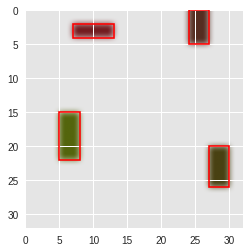

In [4]:
# We take a random image of our training set
im = np.random.randint(N_imgs)
print('Imagine n.', im)

# Let's look the objects contained in it...
fig, ax = plt.subplots(1)
ax.imshow(imgs[im], origin = 'upper', interpolation = 'quadric', extent=[0, side_dim, side_dim, 0])

# ...and the corresponding bounding boxes
for i in range (N_bb):
  [Pc, x, y, w, h] = bounding_boxes[im, i]

# we consider only a percentage of confidence above the Pc_th
# (in our datasets we have Pc with values 0 or 1) but later
# Pc will assume probabilistic values between 0 and 1
  if Pc >= Pc_th:
    rect = patches.Rectangle((x, y) , w, h, ec='r', lw='1.6', fc='none')
    ax.add_patch(rect)

plt.show()

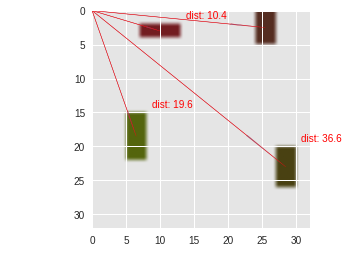

In [5]:
# We look at the image again, this time highlighting the distance of the objects from the origin ...
fig, ax = plt.subplots(1)

ax.imshow(imgs[im], origin = 'upper', interpolation = 'hanning', extent=[0, side_dim, side_dim, 0])

for i in range (N_bb):
  [Pc, x, y, w, h] = bounding_boxes[im, i]

  if Pc >= Pc_th:
    line = patches.Arrow(0, 0, x+(w/2), y+(h/2), .2, ec='r') 
    ax.add_patch(line)
    dida = 'dist: ' + '{:0.1f}'.format(distance[im,i])
    plt.annotate(dida, (x + w + 0.8 , y - 0.8), color='r')

plt.show()

We rearrange the bounding boxes based on the distance from the origin of the objects

In [0]:
order = np.zeros((N_imgs, N_bb), dtype=int)
bboxes = np.zeros(bounding_boxes.shape)

for i in range(N_imgs):
  order[i] = np.argsort(distance[i]) 
  for j in range(N_bb):
    bboxes[i,j] = (bounding_boxes[i, order[i,j]])

Let's start thinking in terms of Machine Learning. 
So we normalize the pixel values contained in our images to have values between -1 and 1 and transfer them to the input X values.

Similarly we normalize the geometric values of our bboxes with respect to the size of the images.

In [7]:
X = (imgs - np.mean(imgs)) / np.std(imgs)
X = np.reshape(X, (N_imgs, side_dim, side_dim, 3))
print(X.shape, np.mean(imgs), np.std(imgs))


Y = np.concatenate((bboxes[:,:, :1], (bboxes[:,:, 1:]/side_dim)), axis=-1)
Y = Y.reshape(N_imgs, -1) 
print(Y.shape)

(12500, 32, 32, 3) 0.8496948295036785 0.17927577363401823
(12500, 20)


Below we see an example of our X values

In [8]:
i = np.random.randint(N_imgs)
print('Images example', i, 'has shape:\n', X[i].shape, '\n')
print('And this is its values:\n', X[i])

Images example 10747 has shape:
 (32, 32, 3) 

And this is its values:
 [[[0.28060217 0.28060217 0.28060217]
  [0.28060217 0.28060217 0.28060217]
  [0.28060217 0.28060217 0.28060217]
  ...
  [0.28060217 0.28060217 0.28060217]
  [0.28060217 0.28060217 0.28060217]
  [0.28060217 0.28060217 0.28060217]]

 [[0.28060217 0.28060217 0.28060217]
  [0.28060217 0.28060217 0.28060217]
  [0.28060217 0.28060217 0.28060217]
  ...
  [0.28060217 0.28060217 0.28060217]
  [0.28060217 0.28060217 0.28060217]
  [0.28060217 0.28060217 0.28060217]]

 [[0.28060217 0.28060217 0.28060217]
  [0.28060217 0.28060217 0.28060217]
  [0.28060217 0.28060217 0.28060217]
  ...
  [0.28060217 0.28060217 0.28060217]
  [0.28060217 0.28060217 0.28060217]
  [0.28060217 0.28060217 0.28060217]]

 ...

 [[0.28060217 0.28060217 0.28060217]
  [0.28060217 0.28060217 0.28060217]
  [0.28060217 0.28060217 0.28060217]
  ...
  [0.28060217 0.28060217 0.28060217]
  [0.28060217 0.28060217 0.28060217]
  [0.28060217 0.28060217 0.28060217]]

 [

And then we observe one of our Y target values

In [9]:
print('...and the target values Y are:\n', Y[3])

...and the target values Y are:
 [1.      0.34375 0.34375 0.21875 0.125   1.      0.375   0.40625 0.125
 0.0625  1.      0.09375 0.59375 0.0625  0.09375 1.      0.65625 0.8125
 0.125   0.0625 ]


We have a homogeneous dataset of the N_imgs elements that we now share in Training set, Validation set, and Test set in relation 80%, 10%, 10%.

In [10]:
i = int(0.8 * N_imgs)
j = int(0.1 * N_imgs)

X_train = X[:i]
Y_train = Y[:i]
train_ex = X_train.shape[0]

X_val = X[i:i+j]
Y_val = Y[i:i+j]
val_ex = X_val.shape[0]

X_test = X[i+j:]
Y_test = Y[i+j:]
test_ex = X_test.shape[0]

dim_test = j # useful for the future 

print('Below the dimensions of X and Y for Training set, Validation set, and Test set respectively\n')
print(X_train.shape, Y_train.shape, X_val.shape, Y_val.shape, X_test.shape, Y_test.shape)

Below the dimensions of X and Y for Training set, Validation set, and Test set respectively

(10000, 32, 32, 3) (10000, 20) (1250, 32, 32, 3) (1250, 20) (1250, 32, 32, 3) (1250, 20)


## The Neural Network
Following our DNN model, is inspired by other detection algorithms and uses three pairs of CNN-MaxPooling layers followed by two fully connected layers, for a total of about 460 thousand parameters.

In [11]:
model = Sequential()
model.add(Conv2D(48, kernel_size=(8, 8), strides=2, padding='same', activation='relu', input_shape=(side_dim,side_dim,3), data_format='channels_last'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid'))
model.add(Conv2D(96, kernel_size=(4, 4), strides=1, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid'))
model.add(Conv2D(192, kernel_size=(2, 2), strides=1, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid'))
model.add(Flatten())
model.add(Dropout(.4))
model.add(Dense(384, activation='relu'))
model.add(Dropout(.4))
model.add(Dense(Y.shape[-1]))

summ = model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 16, 16, 48)        9264      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 48)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 96)          73824     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 96)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 192)         73920     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 2, 2, 192)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 768)               0         
__________

At least for the moment we do not worry too much about the efficiency of the loss function and the optimization algorithm. We use the Mean Squared Error for the first and Adadelta for the second.

In [0]:
model.compile('adadelta', 'mse', metrics=['accuracy'])

Let's start with a cycle of 100 epochs,

In [13]:
history = model.fit(X_train, Y_train, epochs=15, validation_data=(X_val, Y_val), batch_size=16, verbose=1)

Train on 10000 samples, validate on 1250 samples
Epoch 1/15
10000/10000 [==============================] - 9s 852us/step - loss: 0.0261 - acc: 0.2455 - val_loss: 0.0124 - val_acc: 0.0608
Epoch 2/15
10000/10000 [==============================] - 7s 683us/step - loss: 0.0143 - acc: 0.2462 - val_loss: 0.0103 - val_acc: 0.1704
Epoch 3/15
10000/10000 [==============================] - 7s 686us/step - loss: 0.0123 - acc: 0.2369 - val_loss: 0.0095 - val_acc: 0.1912
Epoch 4/15
10000/10000 [==============================] - 7s 687us/step - loss: 0.0111 - acc: 0.2392 - val_loss: 0.0092 - val_acc: 0.1832
Epoch 5/15
10000/10000 [==============================] - 7s 685us/step - loss: 0.0103 - acc: 0.2345 - val_loss: 0.0088 - val_acc: 0.1712
Epoch 6/15
10000/10000 [==============================] - 7s 681us/step - loss: 0.0098 - acc: 0.2375 - val_loss: 0.0082 - val_acc: 0.3280
Epoch 7/15
10000/10000 [==============================] - 7s 677us/step - loss: 0.0094 - acc: 0.2339 - val_loss: 0.0082 - v

##Observation of results
We evaluate the results obtained. We use the Test Set for predictions and define a metric, the IoU (Intersection over Union) that supports those we already have for the training phase - that is, loss error and accuracy.

The Intersection over Union is an incredibly effective measure to understand how much our forecasts approach the correct bounding boxes of the objects in the images. It has values that oscillate between 0 and 1 and the closer they are to 1, the more the area of our predictions approaches that of the correct bounding boxes.

But first let's take a look at our predictions.

In [14]:
# The predictions of the neural network using our Test set as input
pred_y = model.predict(X_test)
pred_bboxes = pred_y
pred_bboxes = pred_bboxes.reshape(len(pred_bboxes), N_bb, -1)
pred_bboxes.shape

(1250, 4, 5)

In [0]:
# We define one of the reference metrics to analyze our results
# the Intersection over Union that measures the correspondence 
# of our predictions with the actual bounding boxes

def IoU(box1, box2):
  '''Intersection over Union (IoU) between box1 and box2
    
  Arguments:
  box1 -- first box, with coordinates (x1, y1, w1, h1)
  box2 -- second box, with coordinates (x2, y2, w2, h2)
  
  Returns:
  iou -- scalar
  '''    
  [x1, y1, w1, h1] = box1
  [x2, y2, w2, h2] = box2
    
  # Intesection area 
  xi1 = np.maximum(x1, x2)
  yi1 = np.maximum(y1, y2)
  xi2 = np.minimum(x1+w1, x2+w2)
  yi2 = np.minimum(y1+h1, y2+h2)
  xi = np.maximum(0., xi2-xi1)
  yi = np.maximum(0., yi2-yi1)
  
  inter_area = np.multiply(xi,yi)

  # Union area
  box1_area = (w1*h1)
  box2_area = (w2*h2)
  union_area = box1_area+box2_area-inter_area
  
  # Calculation of IoU
  iou = inter_area/union_area

  return iou


Test images: 1182
Object:  1
B-box confidence: 0.9926732
B-box coordinates: [6.84 1.22 4.27 4.20]
Object coordinates: [7. 0. 2. 5.]
Test images: 1182
Object:  2
B-box confidence: 0.987296
B-box coordinates: [12.96 7.04 4.26 4.07]
Object coordinates: [9. 8. 3. 6.]
Test images: 1182
Object:  3
B-box confidence: 0.9970391
B-box coordinates: [19.77 12.19 4.43 4.56]
Object coordinates: [21.  9.  3.  5.]
Test images: 1182
Object:  4
B-box confidence: 0.99298537
B-box coordinates: [23.74 25.96 4.12 3.86]
Object coordinates: [24. 28.  7.  2.]


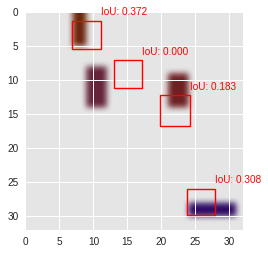

In [16]:
imgTest = (np.reshape(X_test, (dim_test, side_dim, side_dim, 3)) * np.std(imgs)) + np.mean(imgs)

# Consider a random image of our Test set
im = np.random.randint(dim_test)



# We look at the objects contained in it...
fig, ax = plt.subplots(1)
ax.imshow(imgTest[im], origin = 'upper', interpolation = 'quadric', extent=[0, side_dim, side_dim, 0])

# ...and the bounding boxes predicted by the algorithm
for i in range (N_bb):
  [Pc, x , y, w, h] = pred_bboxes[im, i]
  expected_box = Y_test[im,(i*5)+1:(i*5)+5]*side_dim 
  
  x *= side_dim
  y *= side_dim
  w *= side_dim
  h *= side_dim
   
  rect = patches.Rectangle((x, y) , w, h, ec='r', lw='1.4', fc='none')

  dida = 'IoU: ' + '{:0.3f}'.format(IoU([x,y,w,h], expected_box))
  plt.annotate(dida, (x + w , y - 0.8), color='r')

  print('Test images:', im)
  print('Object: ', i+1)
  print('B-box confidence:', Pc)
  print('B-box coordinates:', '[{:0.2f}'.format(x), '{:0.2f}'.format(y), '{:0.2f}'.format(w), '{:0.2f}]'.format(h))
  print('Object coordinates:', expected_box)

  ax.add_patch(rect)

plt.show()


### Valutazione dei risultati
Now we evaluate the results, first by calculating the average IoU for predictions on our Test set.

In [17]:
pred_bboxes.shape, expe_bboxes.shape

((1250, 4, 5), (1250, 4, 5))

In [0]:
# We measure the average IoU of the whole test set 
def mean_IoU(Y_test, pred_bboxes, dim_test, N_bb):
  expe_bboxes = Y_test.reshape(dim_test, N_bb, -1)
  IoU_test = np.zeros((dim_test, N_bb)) 
  iou_global = 0
  for i in range(dim_test):
    for j in range(N_bb):
      IoU_test[i,j] = IoU(pred_bboxes[i,j,1:], expe_bboxes[i,j,1:])

  iou_global = np.mean(IoU_test)
  return iou_global


**Mean Intersection over Union of all Test set:** 

In [19]:
print(mean_IoU(Y_test, pred_bboxes, dim_test, N_bb))

0.1882167596366457


Let's now put on a graph the progress of the training phase for the Training set and the Validation set, with a graph for Accuracy and another for the Loss.

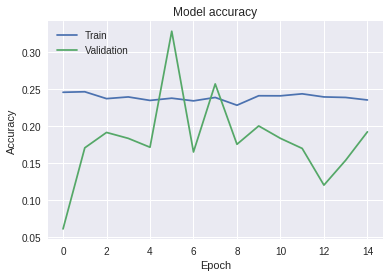

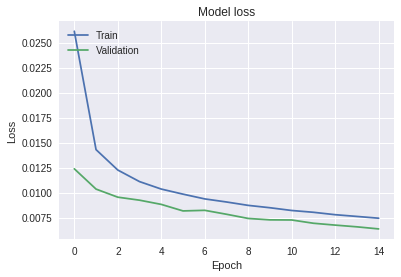

In [20]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

The graphs show how the network is learning. 

##Conclusions
The experiment described lasted just a couple of minutes taking advantage of the Google Colab GPU. Even so, it shows the learning ability of the algorithm and the effectiveness of the solution we have adopted to avoid falling into the problem exposed by Rieke.
<br/><br/>
As shown below, the same network trained for 100 epochs (in a dozen minutes) continues to learn up to a certain point (the Loss Validation Error has a different trend compared to the Loss Training Error). While the average IoU rises to values above 0.23. 

In [0]:

history = model.fit(X_train, Y_train, epochs=100, validation_data=(X_val, Y_val), batch_size=16, verbose=1)

In [27]:
# The predictions of the neural network using our Test set as input
pred_y = model.predict(X_test)
pred_bboxes = pred_y
pred_bboxes = pred_bboxes.reshape(len(pred_bboxes), N_bb, -1)
pred_bboxes.shape

(1250, 4, 5)

In [39]:
print('Test set IoU:', mean_IoU(Y_test, pred_bboxes, dim_test, N_bb))

Test set IoU: 0.23645680831040444


Test images: 941
Object:  1
B-box confidence: 1.0006901
B-box coordinates: [15.27 3.56 4.52 4.59]
Object coordinates: [15.  4.  3.  4.]
Test images: 941
Object:  2
B-box confidence: 1.0008166
B-box coordinates: [8.61 19.31 4.67 4.50]
Object coordinates: [10. 15.  3.  5.]
Test images: 941
Object:  3
B-box confidence: 1.0001205
B-box coordinates: [22.06 12.50 4.05 4.67]
Object coordinates: [20. 16.  4.  3.]
Test images: 941
Object:  4
B-box confidence: 0.9997215
B-box coordinates: [25.45 9.64 3.51 4.97]
Object coordinates: [26.  7.  5.  5.]


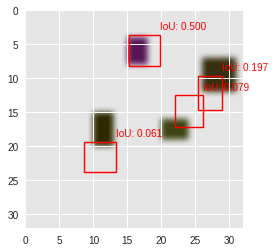

In [42]:
imgTest = (np.reshape(X_test, (dim_test, side_dim, side_dim, 3)) * np.std(imgs)) + np.mean(imgs)

# Consider a random image of our Test set
im = np.random.randint(dim_test)



# We look at the objects contained in it...
fig, ax = plt.subplots(1)
ax.imshow(imgTest[im], origin = 'upper', interpolation = 'quadric', extent=[0, side_dim, side_dim, 0])

# ...and the bounding boxes predicted by the algorithm
for i in range (N_bb):
  [Pc, x , y, w, h] = pred_bboxes[im, i]
  expected_box = Y_test[im,(i*5)+1:(i*5)+5]*side_dim 
  
  x *= side_dim
  y *= side_dim
  w *= side_dim
  h *= side_dim
   
  rect = patches.Rectangle((x, y) , w, h, ec='r', lw='1.4', fc='none')

  dida = 'IoU: ' + '{:0.3f}'.format(IoU([x,y,w,h], expected_box))
  plt.annotate(dida, (x + w , y - 0.8), color='r')

  print('Test images:', im)
  print('Object: ', i+1)
  print('B-box confidence:', Pc)
  print('B-box coordinates:', '[{:0.2f}'.format(x), '{:0.2f}'.format(y), '{:0.2f}'.format(w), '{:0.2f}]'.format(h))
  print('Object coordinates:', expected_box)

  ax.add_patch(rect)

plt.show()

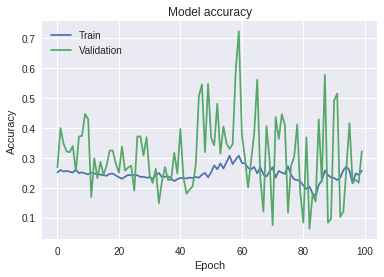

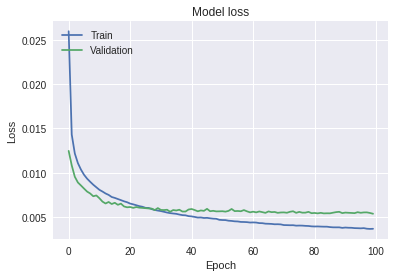

In [36]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

As the trend for the Validation set shows, accuracy fluctuates between rather low values, this depends on the particular shape of our target values. More indicative is the increase in accuracy of the OU and the visualization of the results themselves.

Anyway, the network is certainly improvable. From this base I will carry out other experiments on other Jupyter notebooks by carefully tuning hyperparations, using larger and more complex datasets.